# 测试部分

In [1]:
import torch # 深度学习包
print(torch.version.cuda)# 查看cuda的版本 可以用 nvidia-smi 命令行查看

11.3


In [2]:
# 查看显卡gpu是否可用，如果不可用，也可以用cpu跑，默认是cpu，数据量小不影响
flag = torch.cuda.is_available() #是否可用返回 boolean
if flag:
    print("CUDA可使用")
else:
    print("CUDA不可用")
ngpu= 1 #有几张卡
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("驱动为：",device)
print("GPU型号： ",torch.cuda.get_device_name(0))

CUDA可使用
驱动为： cuda:0
GPU型号：  GeForce GTX 1050 Ti


#  全连接层FC建立

## 导包

In [4]:
import random 
import numpy as np 
import torch
import torch.nn as nn   #所有网络层的基类
import torchvision # torchvision是独立于pytorch的关于图像操作的一些方便工具库。
import torch.nn.functional as F    #  torch神经网络库

## 下载数据集

In [5]:
batch_size=128
# 将数据集合下载到指定目录下,这里的transform表示，数据加载时所需要做的预处理操作
# 加载训练集合
train_dataset=torchvision.datasets.MNIST(
    root='.data',
    train=True,
    transform=torchvision.transforms.ToTensor(),#转化为tensor
    download=True)
# 加载测试集合
test_dataset=torchvision.datasets.MNIST(
    root='.data',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    )

train_loader=torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, #一个批次的大小为128张
        shuffle=True  #随机打乱
        )

test_loader=torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=True
        )


100.0%


Extracting .data\MNIST\raw\train-images-idx3-ubyte.gz to .data\MNIST\raw



102.8%


Extracting .data\MNIST\raw\train-labels-idx1-ubyte.gz to .data\MNIST\raw



100.0%


Extracting .data\MNIST\raw\t10k-images-idx3-ubyte.gz to .data\MNIST\raw



112.7%

Extracting .data\MNIST\raw\t10k-labels-idx1-ubyte.gz to .data\MNIST\raw



## 查看数据集

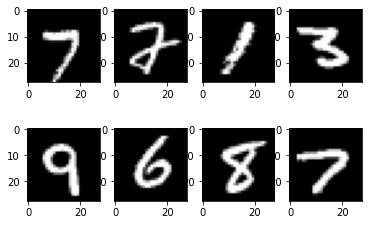

In [6]:
import matplotlib.pyplot as plt  # 简单的画图类
%matplotlib inline
# 加载测试集中的前 8张图片
examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()


# 模型建立

In [31]:
# 输入节点数就为图片的大小：28×28×1,每张图片尺寸 1通道
input_size = 784
# 由于数字为 0-9，因此是10分类问题，因此输出节点数为 10
num_out = 10

In [32]:
# 包含了一个隐含层的全连接神经网络
class MLPNet(nn.Module):
    # 输入数据的维度，中间层的节点数，输出数据的维度
    def __init__(self, input_size, hidden_size, num_out):
        super(MLPNet, self).__init__()
        self.input_size = input_size 
        self.h1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.out = nn.Linear(hidden_size, num_out)
        self.softmax=nn.Softmax(dim=1)# dim表示一维输出

    def forward(self, x):
        h1 = self.h1(x)
        a1 = self.relu1(h1)
        out = self.out(a1)
      #  a_out=self.softmax(out) 这个是没必要的因为我们要把out进行后项传播
        return out
# 建立了一个中间层为 300 的节点三层神经网络，且将模型转为当前环境支持的类型（CPU 或 GPU）
model = MLPNet(input_size, 300, num_out).to(device)
model


MLPNet(
  (h1): Linear(in_features=784, out_features=300, bias=True)
  (relu1): ReLU()
  (out): Linear(in_features=300, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [14]:
# 查看模型的参数
print(model.parameters)

<bound method Module.parameters of MLPNet(
  (h1): Linear(in_features=784, out_features=300, bias=True)
  (relu1): ReLU()
  (out): Linear(in_features=300, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)>


## 损失函数构建反向传播优化器

In [20]:
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数，一般分类问题都用 one-hot + Cross-entropy 回归问题 用MSE
learning_rate = 0.01 #设置学习率为0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)# 定义 Adam 优化器用于梯度下降 当然也可以用SGD

## 模型迭代

In [22]:
len(train_loader) # 一共有469个batch

469

In [27]:
num_epochs = 5
# 数据总长度
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (x_images, y_labels) in enumerate(train_loader):
        # 因为全连接会把一行数据当做一条数据，因此我们需要将一张图片转换到一行上
        # 原始数据集的大小: [ 100, 1，28, 28]
        # resize 后的向量大小: [-1, 784]
        images = x_images.reshape(-1, 28*28).to(device)
        labels = y_labels.to(device)
        # 正向传播以及损失
        y_pre = model(images) #前向传播
        loss = criterion(y_pre, labels)# 计算损失函数
        # 反向传播
        # 梯度清空，反向传播，权重更新
        optimizer.zero_grad()#梯度归零 因为训练的过程通常使用mini-batch方法，所以如果不将梯度清零的话，梯度会与上一个batch的数据相关，因此该函数要写在反向传播和梯度下降之前。
        loss.backward()
        optimizer.step()#执行一次优化步骤，通过梯度下降法来更新参数的值。因为梯度下降是基于梯度的所以在执行optimizer.step()函数前应先执行loss.backward()函数来计算梯度。

        if (i+1) % 64 == 0:
            print( f'epoch [{epoch+1}/{num_epochs}], step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
print("模型训练完成")


epoch [1/5], step [64/469], Loss: 0.0044
epoch [1/5], step [128/469], Loss: 0.0269
epoch [1/5], step [192/469], Loss: 0.0437
epoch [1/5], step [256/469], Loss: 0.1133
epoch [1/5], step [320/469], Loss: 0.0726
epoch [1/5], step [384/469], Loss: 0.1079
epoch [1/5], step [448/469], Loss: 0.2430
epoch [2/5], step [64/469], Loss: 0.0508
epoch [2/5], step [128/469], Loss: 0.0439
epoch [2/5], step [192/469], Loss: 0.0931
epoch [2/5], step [256/469], Loss: 0.0372
epoch [2/5], step [320/469], Loss: 0.0804
epoch [2/5], step [384/469], Loss: 0.0050
epoch [2/5], step [448/469], Loss: 0.1479
epoch [3/5], step [64/469], Loss: 0.1065
epoch [3/5], step [128/469], Loss: 0.2333
epoch [3/5], step [192/469], Loss: 0.1784
epoch [3/5], step [256/469], Loss: 0.0632
epoch [3/5], step [320/469], Loss: 0.0865
epoch [3/5], step [384/469], Loss: 0.0340
epoch [3/5], step [448/469], Loss: 0.0029
epoch [4/5], step [64/469], Loss: 0.0043
epoch [4/5], step [128/469], Loss: 0.0398
epoch [4/5], step [192/469], Loss: 0.0

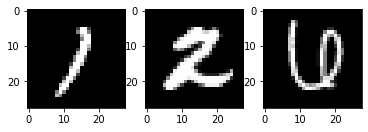

上面三张图片的真实结果： [1 2 6]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [28]:
# 测试样例
examples = iter(test_loader)
example_data, example_targets = examples.next()

# 图片的展示
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

# 结果的预测
images = example_data
images = images.reshape(-1, 28*28).to(device)
labels = labels.to(device)

# 正向传播以及损失的求取
outputs = model(images)
# 将 Tensor 类型的变量 example_targets 转为 numpy 类型的，方便展示
print("上面三张图片的真实结果：", example_targets[0:3].detach().numpy())
# 将得到预测结果
# 由于预测结果是 N×10 的矩阵，因此利用 np.argmax 函数取每行最大的那个值，最为预测值
print("上面三张图片的预测结果：", np.argmax(outputs[0:3].detach().numpy(), axis=1))


# test集上测试

In [29]:
# 测试数据，计算模型的识别准确率
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        # 和训练代码一致
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)

        # 进行模型训练的准确度
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')


Accuracy of the network on the 10000 test images: 97.14 %
